In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
import tensorflow_datasets as tfds

In [5]:
tfds.list_builders()

['abstract_reasoning',
 'accentdb',
 'aeslc',
 'aflw2k3d',
 'ag_news_subset',
 'ai2_arc',
 'ai2_arc_with_ir',
 'amazon_us_reviews',
 'anli',
 'arc',
 'bair_robot_pushing_small',
 'bccd',
 'beans',
 'big_patent',
 'bigearthnet',
 'billsum',
 'binarized_mnist',
 'binary_alpha_digits',
 'blimp',
 'bool_q',
 'c4',
 'caltech101',
 'caltech_birds2010',
 'caltech_birds2011',
 'cars196',
 'cassava',
 'cats_vs_dogs',
 'celeb_a',
 'celeb_a_hq',
 'cfq',
 'chexpert',
 'cifar10',
 'cifar100',
 'cifar10_1',
 'cifar10_corrupted',
 'citrus_leaves',
 'cityscapes',
 'civil_comments',
 'clevr',
 'clic',
 'clinc_oos',
 'cmaterdb',
 'cnn_dailymail',
 'coco',
 'coco_captions',
 'coil100',
 'colorectal_histology',
 'colorectal_histology_large',
 'common_voice',
 'coqa',
 'cos_e',
 'cosmos_qa',
 'covid19sum',
 'crema_d',
 'curated_breast_imaging_ddsm',
 'cycle_gan',
 'deep_weeds',
 'definite_pronoun_resolution',
 'dementiabank',
 'diabetic_retinopathy_detection',
 'div2k',
 'dmlab',
 'downsampled_imagenet',
 

In [7]:
(train_data, val_data), metadata = tfds.load(name="food101",
                                            split=["train", "validation"],
                                            shuffle_files=True,
                                            as_supervised=True,
                                            with_info=True)

In [11]:
metadata

tfds.core.DatasetInfo(
    name='food101',
    version=2.0.0,
    description='This dataset consists of 101 food categories, with 101'000 images. For each class, 250 manually reviewed test images are provided as well as 750 training images. On purpose, the training images were not cleaned, and thus still contain some amount of noise. This comes mostly in the form of intense colors and sometimes wrong labels. All images were rescaled to have a maximum side length of 512 pixels.',
    homepage='https://www.vision.ee.ethz.ch/datasets_extra/food-101/',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
    }),
    total_num_examples=101000,
    splits={
        'train': 75750,
        'validation': 25250,
    },
    supervised_keys=('image', 'label'),
    citation="""@inproceedings{bossard14,
      title = {Food-101 -- Mining Discriminative Components with Random Forests},
      

In [16]:
class_names = metadata.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [27]:
sample = train_data.take(1).as_numpy_iterator().next()

print(f"Shape: {sample[0].shape} | Class: {class_names[sample[1]]}")

Shape: (512, 512, 3) | Class: bread_pudding


In [28]:
sample[0].max()

255

In [29]:
sample[0].min()

0

In [30]:
# Note: Images haven't been scaled at this point

In [31]:
def plot_random_image(data, classes=None):
  sample = data.take(1).as_numpy_iterator().next()
  image = sample[0]
  cls = classes[sample[1]]
  plt.title(cls)
  plt.axis(False)
  plt.imshow(image)

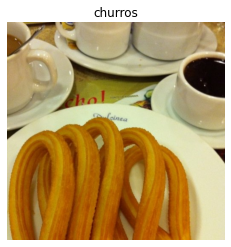

In [33]:
plot_random_image(train_data, class_names)

In [57]:
def preprocess_image(image, label, img_shape=224):
  image = tf.cast(tf.image.resize(image, size=[img_shape, img_shape]), dtype=tf.float32)
  return image, label

In [59]:
preprocessed = preprocess_image(sample[0], sample[1])
preprocessed[0].numpy().max()

247.75961

In [60]:
train_data = train_data.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
train_data = train_data.shuffle(buffer_size=100).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

val_data = val_data.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
val_data = val_data.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

In [64]:
train_data.take(1).as_numpy_iterator().next()[0].shape

(32, 224, 224, 3)

In [66]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-b661d559-93f5-7be5-0971-e59f9f013448)


In [67]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


In [68]:
mixed_precision.global_policy()

<Policy "mixed_float16">

In [71]:
from keras import layers
from tensorflow.keras.applications import EfficientNetB0

In [76]:
image_shape = (224, 224, 3)
base_model = EfficientNetB0(include_top=False)

base_model.trainable = False

inputs = layers.Input(shape=image_shape, name="input_layer")
x = base_model(inputs, training=False)
x = layers.GlobalMaxPooling2D(name="pooling_layer")(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation("softmax", name="softmax_activation")(x)

model_0 = tf.keras.Model(inputs, outputs)

model_0.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [77]:
model_0.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalMaxPoo  (None, 1280)             0         
 ling2D)                                                         
                                                                 
 dense_2 (Dense)             (None, 101)               129381    
                                                                 
 softmax_activation (Activat  (None, 101)              0         
 ion)                                                            
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-train

In [78]:
for num, layer in enumerate(model_0.layers[1].layers):
  print(num, layer.name, layer.trainable, layer.dtype_policy)

0 input_3 False <Policy "float32">
1 rescaling_2 False <Policy "mixed_float16">
2 normalization_2 False <Policy "mixed_float16">
3 stem_conv_pad False <Policy "mixed_float16">
4 stem_conv False <Policy "mixed_float16">
5 stem_bn False <Policy "mixed_float16">
6 stem_activation False <Policy "mixed_float16">
7 block1a_dwconv False <Policy "mixed_float16">
8 block1a_bn False <Policy "mixed_float16">
9 block1a_activation False <Policy "mixed_float16">
10 block1a_se_squeeze False <Policy "mixed_float16">
11 block1a_se_reshape False <Policy "mixed_float16">
12 block1a_se_reduce False <Policy "mixed_float16">
13 block1a_se_expand False <Policy "mixed_float16">
14 block1a_se_excite False <Policy "mixed_float16">
15 block1a_project_conv False <Policy "mixed_float16">
16 block1a_project_bn False <Policy "mixed_float16">
17 block2a_expand_conv False <Policy "mixed_float16">
18 block2a_expand_bn False <Policy "mixed_float16">
19 block2a_expand_activation False <Policy "mixed_float16">
20 block2a_

In [79]:
history_0 = model_0.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=val_data,
                        validation_steps=len(val_data))

Epoch 1/5
2368/2368 [==============================] - 273s 107ms/step - loss: 3.3239 - accuracy: 0.4278 - val_loss: 2.4601 - val_accuracy: 0.5364
Epoch 2/5
2368/2368 [==============================] - 223s 94ms/step - loss: 2.4161 - accuracy: 0.5607 - val_loss: 2.5525 - val_accuracy: 0.5524
Epoch 3/5
2368/2368 [==============================] - 218s 92ms/step - loss: 2.1687 - accuracy: 0.5983 - val_loss: 2.5748 - val_accuracy: 0.5638
Epoch 4/5
2368/2368 [==============================] - 252s 106ms/step - loss: 1.9981 - accuracy: 0.6261 - val_loss: 2.3775 - val_accuracy: 0.5981
Epoch 5/5
2368/2368 [==============================] - 248s 105ms/step - loss: 1.8916 - accuracy: 0.6444 - val_loss: 2.7690 - val_accuracy: 0.5755


In [80]:
def plot_loss_curves(history):
  loss = history.history["loss"]
  accuracy = history.history["accuracy"]
  val_loss = history.history["val_loss"]
  val_accuracy = history.history["val_accuracy"]
  epochs = np.arange(0, len(loss))

  plt.figure(figsize=(10, 14))
  plt.subplot(2, 1, 1)
  plt.title("Accuracy")
  plt.plot(epochs, accuracy, label="accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.legend()

  plt.subplot(2, 1, 2)
  plt.title("Loss")
  plt.plot(epochs, loss, label="loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.legend()

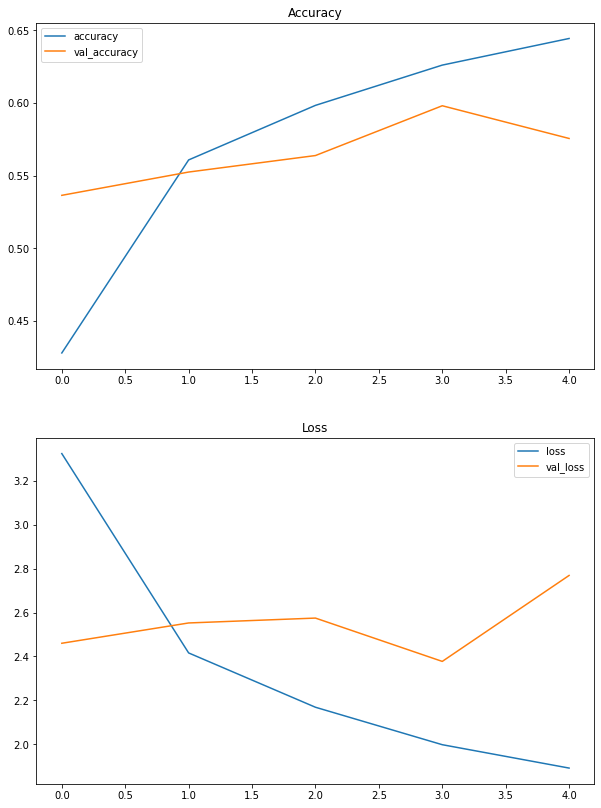

In [81]:
plot_loss_curves(history_0)

In [82]:
image_shape

(224, 224, 3)

In [83]:
base_model.trainable = True
for layer in base_model.layers[:-5]:
  layer.trainable = False

inputs = layers.Input(shape=image_shape, name="input_layer")
x = base_model(inputs)
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
outputs = layers.Dense(len(class_names), activation="softmax", name="output_layer")(x)

model_1 = tf.keras.Model(inputs, outputs)
model_1.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                metrics=["accuracy"])

In [84]:
# Learning rate tuner
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                 factor=0.2,
                                                 patience=2,
                                                 verbose=1,
                                                 min_lr=1e-7)

In [85]:
history_1 = model_1.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=val_data,
                        validation_steps=len(val_data),
                        callbacks=[reduce_lr])

Epoch 1/5
2368/2368 [==============================] - 225s 90ms/step - loss: 2.3391 - accuracy: 0.4710 - val_loss: 1.3650 - val_accuracy: 0.6501 - lr: 1.0000e-04
Epoch 2/5
2368/2368 [==============================] - 211s 89ms/step - loss: 1.5266 - accuracy: 0.6169 - val_loss: 1.1484 - val_accuracy: 0.6950 - lr: 1.0000e-04
Epoch 3/5
2368/2368 [==============================] - 211s 89ms/step - loss: 1.3384 - accuracy: 0.6570 - val_loss: 1.0575 - val_accuracy: 0.7171 - lr: 1.0000e-04
Epoch 4/5
2368/2368 [==============================] - 252s 106ms/step - loss: 1.2217 - accuracy: 0.6859 - val_loss: 0.9996 - val_accuracy: 0.7291 - lr: 1.0000e-04
Epoch 5/5
2368/2368 [==============================] - 210s 89ms/step - loss: 1.1356 - accuracy: 0.7047 - val_loss: 0.9620 - val_accuracy: 0.7364 - lr: 1.0000e-04


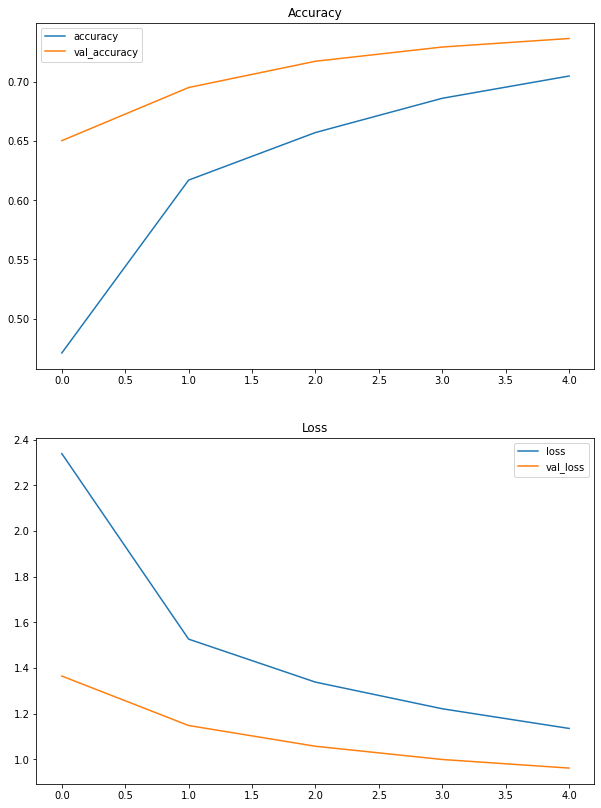

In [86]:
plot_loss_curves(history_1)

# Conclusion: Meh, not bad